 Challenge Boston Marathon

 
You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import csv
import re
from scipy import stats, integrate
from sklearn.preprocessing import normalize
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

In [60]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


Initial Data Processing

In [61]:
df = pd.read_csv('gdrive/My Drive/marathon_results_201701.csv')
df.columns

Index(['Unnamed: 0', 'Bib', 'Name', 'Age', 'Gender', 'City', 'State',
       'Country', 'Citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'Half',
       '25K', '30K', '35K', '40K', 'Pace', 'Proj Time', 'Official Time',
       'Overall', 'Gender.1', 'Division'],
      dtype='object')

In [62]:
df.describe()

,Unnamed: 0,Age,Overall,Gender.1,Division
count,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000
mean,13204.500000,42.587732,13206.260091,6660.973230,1588.796706
std,7624.054641,11.419467,7624.370496,3910.031525,1423.199500
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,6602.250000,34.000000,6604.250000,3302.250000,502.000000
50%,13204.500000,43.000000,13206.500000,6603.500000,1154.000000
75%,19806.750000,51.000000,19808.750000,9904.750000,2190.750000
max,26409.000000,84.000000,26411.000000,14438.000000,5846.000000


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     26410 non-null  int64 
 1   Bib            26410 non-null  object
 2   Name           26410 non-null  object
 3   Age            26410 non-null  int64 
 4   Gender         26410 non-null  object
 5   City           26410 non-null  object
 6   State          22815 non-null  object
 7   Country        26410 non-null  object
 8   Citizen        1254 non-null   object
 9   Unnamed: 9     91 non-null     object
 10  5K             26410 non-null  object
 11  10K            26410 non-null  object
 12  15K            26410 non-null  object
 13  20K            26410 non-null  object
 14  Half           26410 non-null  object
 15  25K            26410 non-null  object
 16  30K            26410 non-null  object
 17  35K            26410 non-null  object
 18  40K            26410 non-n

In [5]:
df['Citizen'].describe()

count     1254
unique      85
top        GBR
freq       141
Name: Citizen, dtype: object

In [37]:
df.Citizen.unique()

array([nan, 'MAR', 'ZIM', 'KEN', 'CRC', 'IRL', 'FRA', 'AUS', 'TRI', 'NED',
       'FIN', 'MEX', 'CHN', 'GBR', 'GER', 'JPN', 'VEN', 'CHI', 'BEL',
       'USA', 'ARG', 'CAN', 'ECU', 'MOZ', 'TUR', 'ITA', 'NZL', 'IND',
       'GRE', 'HKG', 'EST', 'HUN', 'GUA', 'POL', 'SWE', 'ESP', 'RSA',
       'DOM', 'NOR', 'COL', 'UKR', 'CZE', 'BRA', 'SUI', 'SIN', 'LTU',
       'SRI', 'AUT', 'POR', 'SVK', 'TWN', 'SLO', 'EGY', 'ISR', 'BLR',
       'PHI', 'ROU', 'BUL', 'ESA', 'RUS', 'ETH', 'KOR', 'MAS', 'ALB',
       'HON', 'URU', 'CAF', 'DEN', 'TUN', 'BAN', 'THA', 'NAM', 'INA',
       'AZE', 'BIH', 'PER', 'GUY', 'SRB', 'LAT', 'PAK', 'CUB', 'NGR',
       'JAM', 'ZAM', 'LIB', 'CAM'], dtype=object)

In [47]:
df= df.drop('Citizen',axis=1).dropna()
df.head()

,Unnamed: 0,Bib,Name,Age,Gender,City,State,Country,Unnamed: 9,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender.1,Division
493,493,2213,"Kloehn, Ian",22,M,Menomonee Falls,WI,USA,VI,0:19:14,0:38:03,0:57:06,1:16:57,1:21:17,1:37:02,1:57:58,2:18:53,2:39:25,0:06:26,-,2:48:34,494,459,371
741,741,1322,"Oliver, Matthew",28,M,Santee,CA,USA,VI,0:20:16,0:39:42,0:59:29,1:19:31,1:23:47,1:39:33,2:00:31,2:21:52,2:43:22,0:06:36,-,2:52:46,742,699,555
1691,1691,1789,"Scheidies, Aaron",35,M,Seattle,WA,USA,VI,0:19:01,0:39:27,0:59:38,1:20:15,1:24:47,1:41:27,2:03:39,2:26:43,2:51:50,0:06:58,-,3:02:17,1692,1577,1160
2365,2365,1364,"Balcom, Donald C.",43,M,Hollywood,MD,USA,VI,0:21:35,0:43:33,1:05:09,1:27:41,1:32:25,1:49:56,2:13:12,2:36:16,2:58:08,0:07:09,-,3:07:24,2366,2170,350
2858,2858,5484,"Broca, Adrian",39,M,Los Angeles,CA,USA,VI,0:21:33,0:42:57,1:04:24,1:26:08,1:30:52,1:48:22,2:11:32,2:35:44,2:59:14,0:07:16,-,3:10:13,2859,2596,1707


In [64]:
df.isnull().sum()

Unnamed: 0           0
Bib                  0
Name                 0
Age                  0
Gender               0
City                 0
State             3595
Country              0
Citizen          25156
Unnamed: 9       26319
5K                   0
10K                  0
15K                  0
20K                  0
Half                 0
25K                  0
30K                  0
35K                  0
40K                  0
Pace                 0
Proj Time            0
Official Time        0
Overall              0
Gender.1             0
Division             0
dtype: int64

In [13]:
df.columns

Index(['Unnamed: 0', 'Bib', 'Name', 'Age', 'M/F', 'City', 'State', 'Country',
       'Citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'Half', '25K',
       '30K', '35K', '40K', 'Pace', 'Proj Time', 'Official Time', 'Overall',
       'Gender', 'Division'],
      dtype='object')

In [65]:
df.loc[(df['State'].isnull()) & (df["Country"] == "USA")]

,Unnamed: 0,Bib,Name,Age,Gender,City,State,Country,Citizen,Unnamed: 9,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender.1,Division


In [69]:
# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')

# Convert checkpoints to numeric types
splits = ['10K', '25K', '35K', '30K', '5K', 'Half', '20K', '40K' ]
for split in splits:
 df[split] = pd.to_numeric(df[split], errors='coerce').isnull()

# Drop Columns name since we're not looking at individuals.
# Drop citizenship column since 96% of racers don't report their 
# citizenship rather their country of residence.
#df = df.drop(columns = ['Name'])

# Drop the one person who didn't say which city they're from (why are you like this?)
df = df.dropna(subset=['City'])

# Rows misisng states all belong to people who live outside of the US
# give them a new variable for out of USA residence for state
df['State'] = df['State'].fillna(value='ZZ')

In [71]:
# One hot endcode gender so that it's a binary
# for plotting and modeling
df = pd.get_dummies(df,columns=['Gender'])

In [72]:
df.dropna()

,Unnamed: 0,Bib,Age,City,State,Country,Unnamed: 9,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender.1,Division,Gender_F,Gender_M
493,493,2213,22,Menomonee Falls,WI,USA,VI,False,False,0:57:06,False,False,False,False,False,False,0:06:26,,2:48:34,494,459,371,0,1
741,741,1322,28,Santee,CA,USA,VI,False,False,0:59:29,False,False,False,False,False,False,0:06:36,,2:52:46,742,699,555,0,1
1691,1691,1789,35,Seattle,WA,USA,VI,False,False,0:59:38,False,False,False,False,False,False,0:06:58,,3:02:17,1692,1577,1160,0,1
2365,2365,1364,43,Hollywood,MD,USA,VI,False,False,1:05:09,False,False,False,False,False,False,0:07:09,,3:07:24,2366,2170,350,0,1
2858,2858,5484,39,Los Angeles,CA,USA,VI,False,False,1:04:24,False,False,False,False,False,False,0:07:16,,3:10:13,2859,2596,1707,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,26404,25141,19,Belmont,MI,USA,MI,False,False,1:47:50,False,False,False,False,False,False,0:16:12,,7:04:33,26406,14435,4773,0,1
26405,26405,25166,61,Ontario,CA,USA,MI,False,False,2:23:35,False,False,False,False,False,False,0:16:24,,7:09:39,26407,11972,344,1,0
26406,26406,25178,25,Fayetteville,NC,USA,MI,False,False,1:52:17,False,False,False,False,False,False,0:16:40,,7:16:59,26408,14436,4774,0,1
26408,26408,25268,64,New York,NY,USA,MI,False,False,2:17:17,False,False,False,False,False,False,0:16:49,,7:20:44,26410,14437,1043,0,1


Exploratory Data Analysis

Gender

In [73]:
# Define the y labels for the visualization
gender_labels = ['{} (n = {})'.format(Gender, df[df['gender_F'] == Gender].shape[0]) for Gender in df['gender_F'].unique()]
gender_colors = {0:'#4286f4', 1:'#ee40f7'} # gender

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['gender_F'], palette=gender_colors)
sns.despine()
plt.title('Count of participants by gender (M:0 || F:1)')
plt.xlabel('')
plt.ylabel('')
plt.yticks([0,1], labels = gender_labels)
plt.show()

KeyError: ignored


Age Brackets
The Boston marathon divides its qualifying times into 5 year age brackets (except 18-34), so those are what I'll use for feature engineering and visualization going forward.

In [76]:
# Because the first and last bins aren't equal to the others, I'll have to manually bin them
age_bins= [18,35,40,45,50,55,60,65,70,75,80,(df['Age'].max()+1)]

# Create a column for age groups
age_labels = ['18-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
df['age_groups'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

The feature 'bib' is the number printed on a participant's bib. It contains information about a participant's start wave.
Bib numbers indicate which wave of the race the participant was assigned to as well as what time of day they began the race. Participants whose bib began with F were assigned to the women's elite wave, while participants whose bib began with W were assigned to the push wheelchair elite wave.

<Figure size 1008x72 with 0 Axes>

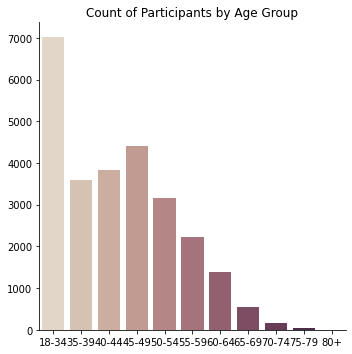

In [77]:
# Plot the figure
plt.figure(figsize=(14,1))
sns.catplot(x="age_groups", 
            kind="count", 
            palette="ch:.25", 
            data=df)
plt.title('Count of Participants by Age Group')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [78]:

# Remove letter from women and wheelchair racers
# To not mix the wheelchair athletes with the elite runners
# I gave them real large numbers starting with 4000.
df['Bib'] = df['Bib'].str.replace('W','4000')
df['Bib'] = df['Bib'].str.replace('F','1.')

#convert column to numeric type
df['Bib'] = pd.to_numeric(df['Bib'])

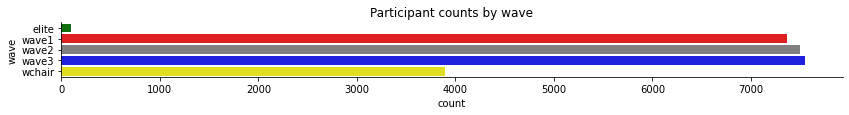

In [85]:

# bib numbers for each wave
wave_bins= [0,101,9000,18000,27000,(df['Bib'].max()+1)]

# Create a column for waves
wave_labels = ['elite', 'wave1', 'wave2', 'wave3', 'wchair']

# Create a wave column
df['wave'] = pd.cut(df['Bib'], bins=wave_bins, labels=wave_labels, right=False)

# wave colors
wave_colors = ["green", "red", "grey", "blue", "yellow", "orange"]

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['wave'], palette=wave_colors)
sns.despine()
plt.title('Participant counts by wave')
plt.show()

In [86]:

print('Number of Represented Countries: {}\n{}'.format(len(df['Country'].unique()), df['Country'].unique()))

print('\nNumber of Represented States: {}\n{}'.format(len(df['State'].unique()), df['State'].unique()))

Number of Represented Countries: 91
['KEN' 'USA' 'JPN' 'ETH' 'ZIM' 'MEX' 'BRN' 'BRA' 'CAN' 'ITA' 'NED' 'IRL'
 'BDI' 'GBR' 'GER' 'ESP' 'SUI' 'COL' 'NOR' 'POL' 'FRA' 'RUS' 'POR' 'CRC'
 'BEL' 'NZL' 'PER' 'DOM' 'PAN' 'AUS' 'DEN' 'MAS' 'PHI' 'CHI' 'AUT' 'ARG'
 'SIN' 'CHN' 'TWN' 'GUA' 'RSA' 'HKG' 'SLO' 'EST' 'TUR' 'EGY' 'IND' 'UAE'
 'SWE' 'BER' 'KOR' 'CAY' 'FIN' 'LTU' 'GRE' 'CRO' 'ISL' 'LUX' 'FLK' 'VEN'
 'JAM' 'THA' 'HON' 'SRB' 'CZE' 'ISR' 'MLT' 'HUN' 'ECU' 'KSA' 'ESA' 'MAR'
 'ROU' 'LAT' 'UKR' 'SMR' 'BUL' 'ALG' 'NCA' 'SVK' 'AND' 'BAR' 'INA' 'GRN'
 'URU' 'PAR' 'TCA' 'KUW' 'TRI' 'MGL' 'NGR']

Number of Represented States: 69
['ZZ' 'OR' 'CA' 'AZ' 'CO' 'UT' 'MA' 'NY' 'NC' 'MI' 'TN' 'TX' 'MN' 'AB'
 'VA' 'IN' 'DC' 'MD' 'NH' 'CT' 'IA' 'ON' 'QC' 'AL' 'ID' 'PA' 'IL' 'AK'
 'FL' 'KS' 'SC' 'WI' 'MO' 'OH' 'NJ' 'OK' 'WA' 'GA' 'KY' 'PE' 'RI' 'WV'
 'NV' 'ME' 'VT' 'NM' 'BC' 'NB' 'NE' 'AR' 'AE' 'LA' 'MT' 'WY' 'NS' 'SD'
 'DE' 'HI' 'PR' 'MS' 'AA' 'AP' 'GU' 'ND' 'MB' 'NL' 'SK' 'VI' 'YT']


In [105]:

# Define a function to streamline descriptive statistic retrieval
def get_descriptives(column, category):
    c_n = df[df[column] == category]['Official Time'].shape[0]
    c_avg = round(df[df[column] == category]['Official Time'].mean(),2)  
    print('In 2017 there were {} {} athletes\nWho on average finished the race in'
          ' {} minutes\n'.format(c_n, category, c_avg))    

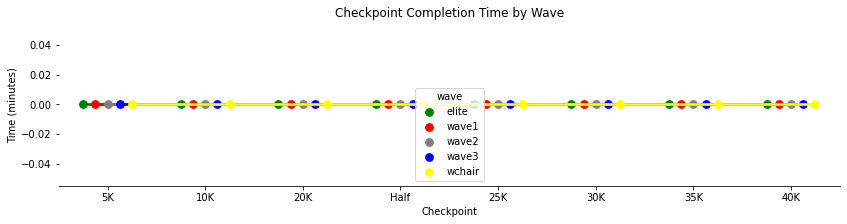

In [103]:
# Make the checkpoint completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5K', '10K', '20K', 'Half', '25K', '30K', '35K', '40K'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['wave'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='wave',
            palette=wave_colors,
            ci=95,
            orient="v",
            dodge=0.5)

sns.despine(left=True)

plt.title('Checkpoint Completion Time by Wave')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

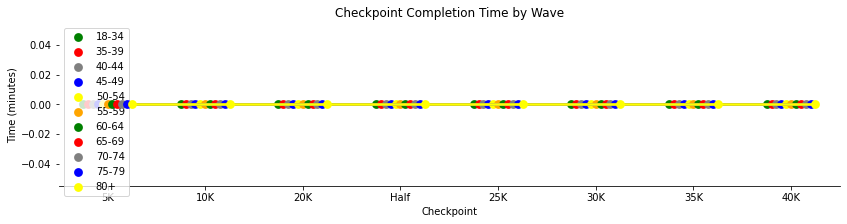

In [108]:
 #Make the checkpoint completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5K', '10K', '20K', 'Half', '25K', '30K', '35K', '40K'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['age_groups'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='age_groups',
            palette=wave_colors,
            ci=95,
            orient="v",
            dodge=0.5)

sns.despine(left=True)

plt.title('Checkpoint Completion Time by Wave')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')
plt.legend(loc='upper left')
plt.show()

Clustering

In [ ]:
features = pd.DataFrame()

# Add country
# features['country'] = df['country'] # only keep if one hot encoding all countries

# Add age
features['age'] = df['Age']

# Add gender to the feature set.
#features['is_female'] = df['gender_F']

# Add countries with top 10 finishers - as binary features
for country in ['RSA', 'JPN', 'SUI', 'ESP', 'USA', 'POL', 'THA', 'FRA', 'CAN', 'CHN', 'OTHER']:
    features[country] = np.where(df['Country'] == country, 1, 0)

# Add waves as binary columns.
for wave in df['wave'].unique():
    features[wave] = np.where(df['wave'] == wave, 1, 0)
    
# Rescale and add overall finishing position.
features['overall'] = df['overall']

# Rescale and add division finishing position.
features['division'] = df['division']

# Rescale and add gender division finishing position.
features['genderdiv'] = df['genderdiv']

# Add checkpoint times.
for col in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official']:
    features[col] = df[col]

In [110]:
from sklearn.preprocessing import StandardScaler
X = features

# First center and scale the data
scaled_data = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=list(features))
X_scaled.head(2)

ValueError: ignored

In [111]:

# Utilizing Two Components
# Perform PCA for graphing purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]

X_pca

NameError: ignored